In [1]:
from helper import*
import params as cfg
import sys

In [2]:
# group-task-time
M = [['m11_1.zip'],['m12_1.zip']]
localDir = "/Users/joshuaighalo/Downloads/Mind_Monitor/"
destDir = "/Users/joshuaighalo/Downloads/Mind_Monitor/dest/"
os.system('rm -rf %s/*' % destDir)
fs_setting = 'constant'

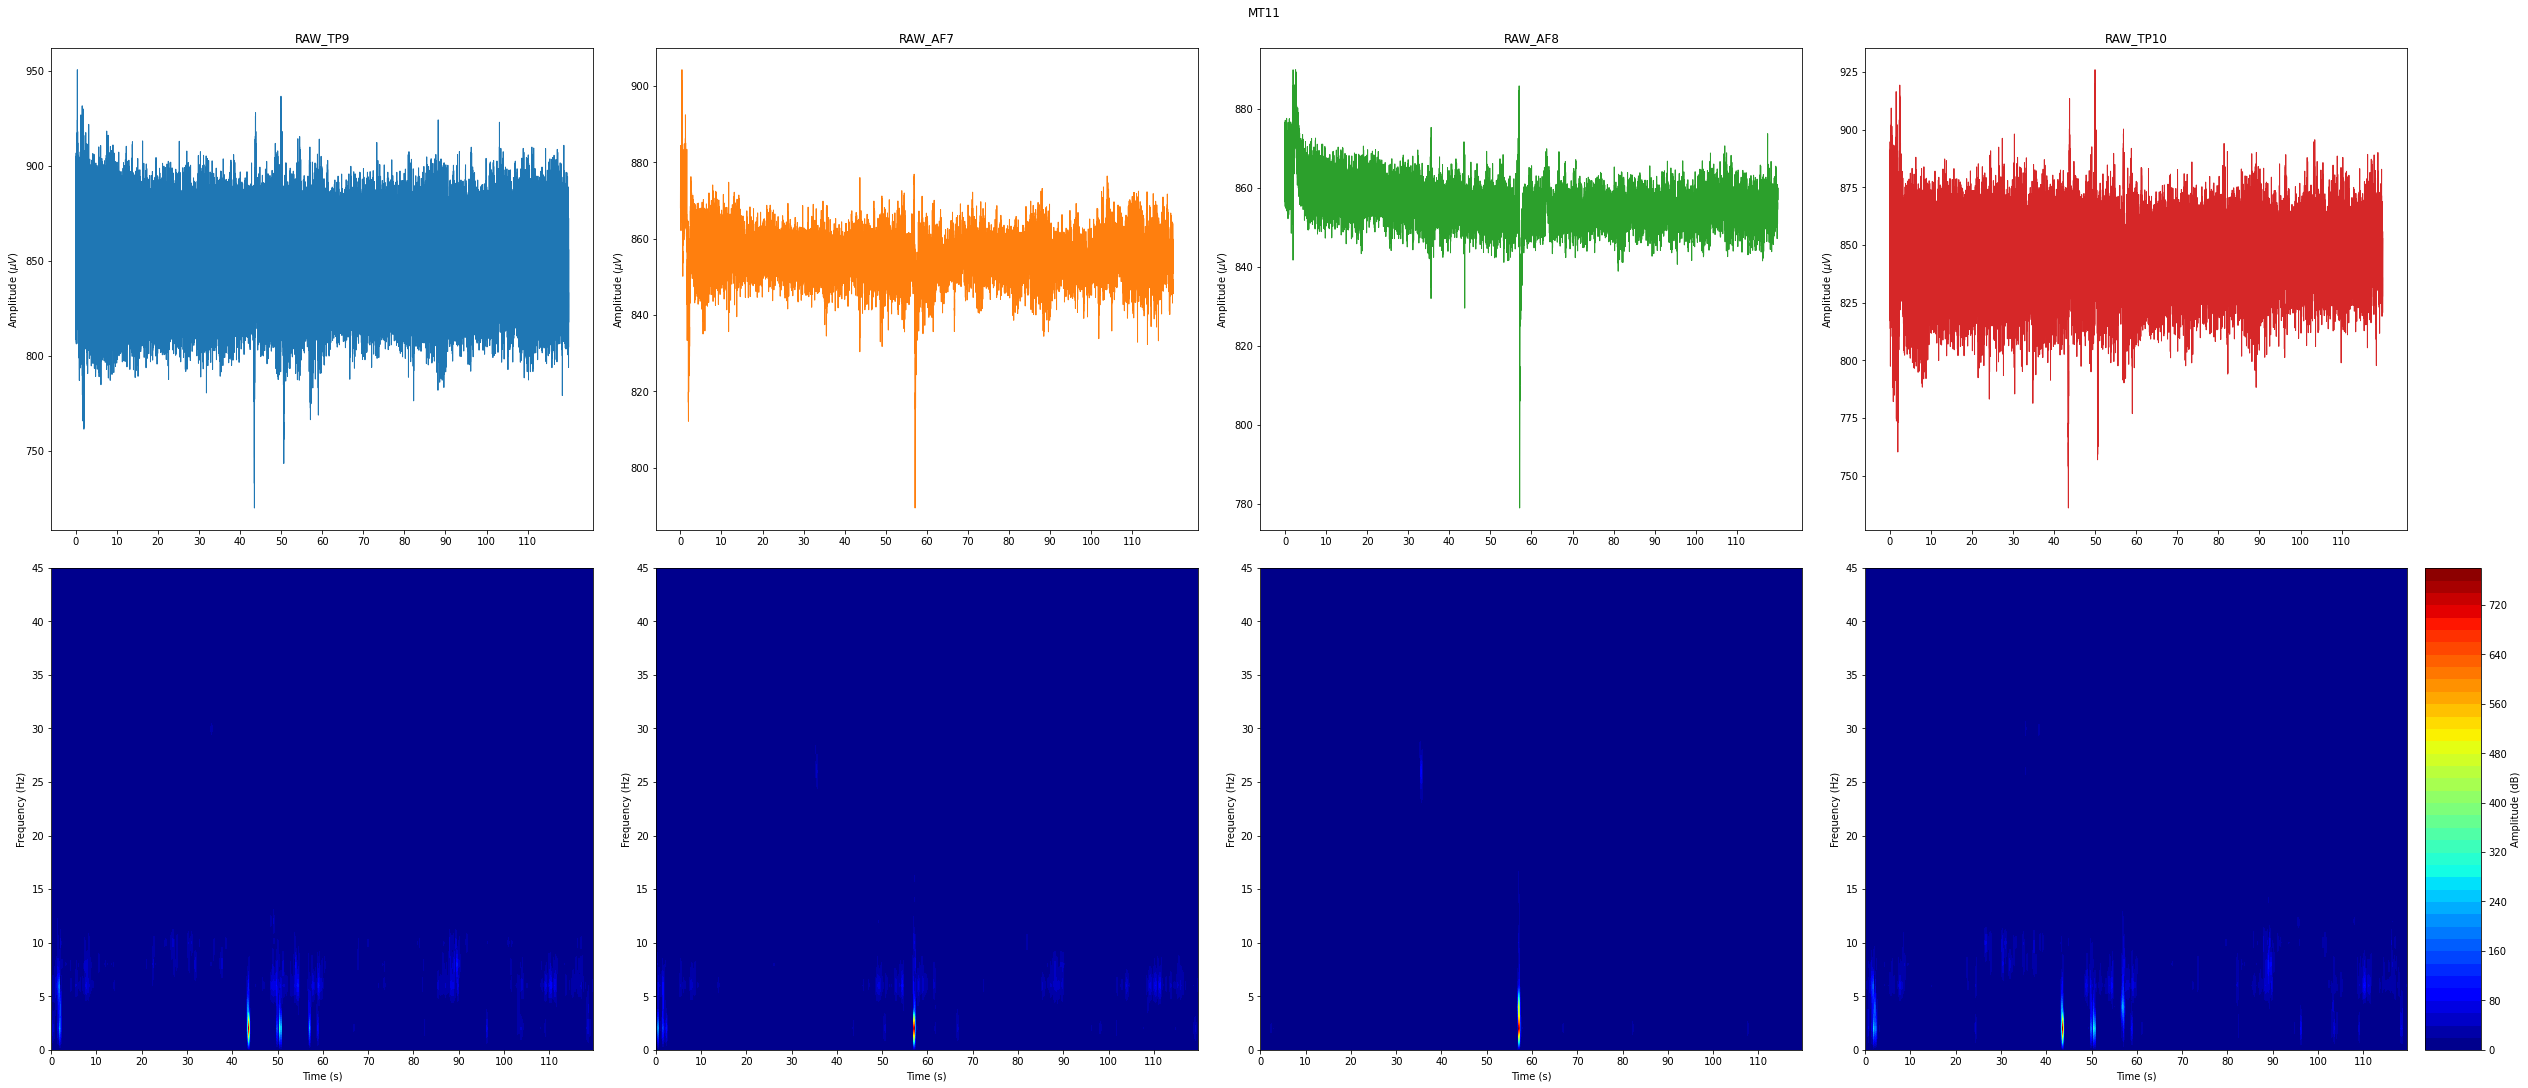

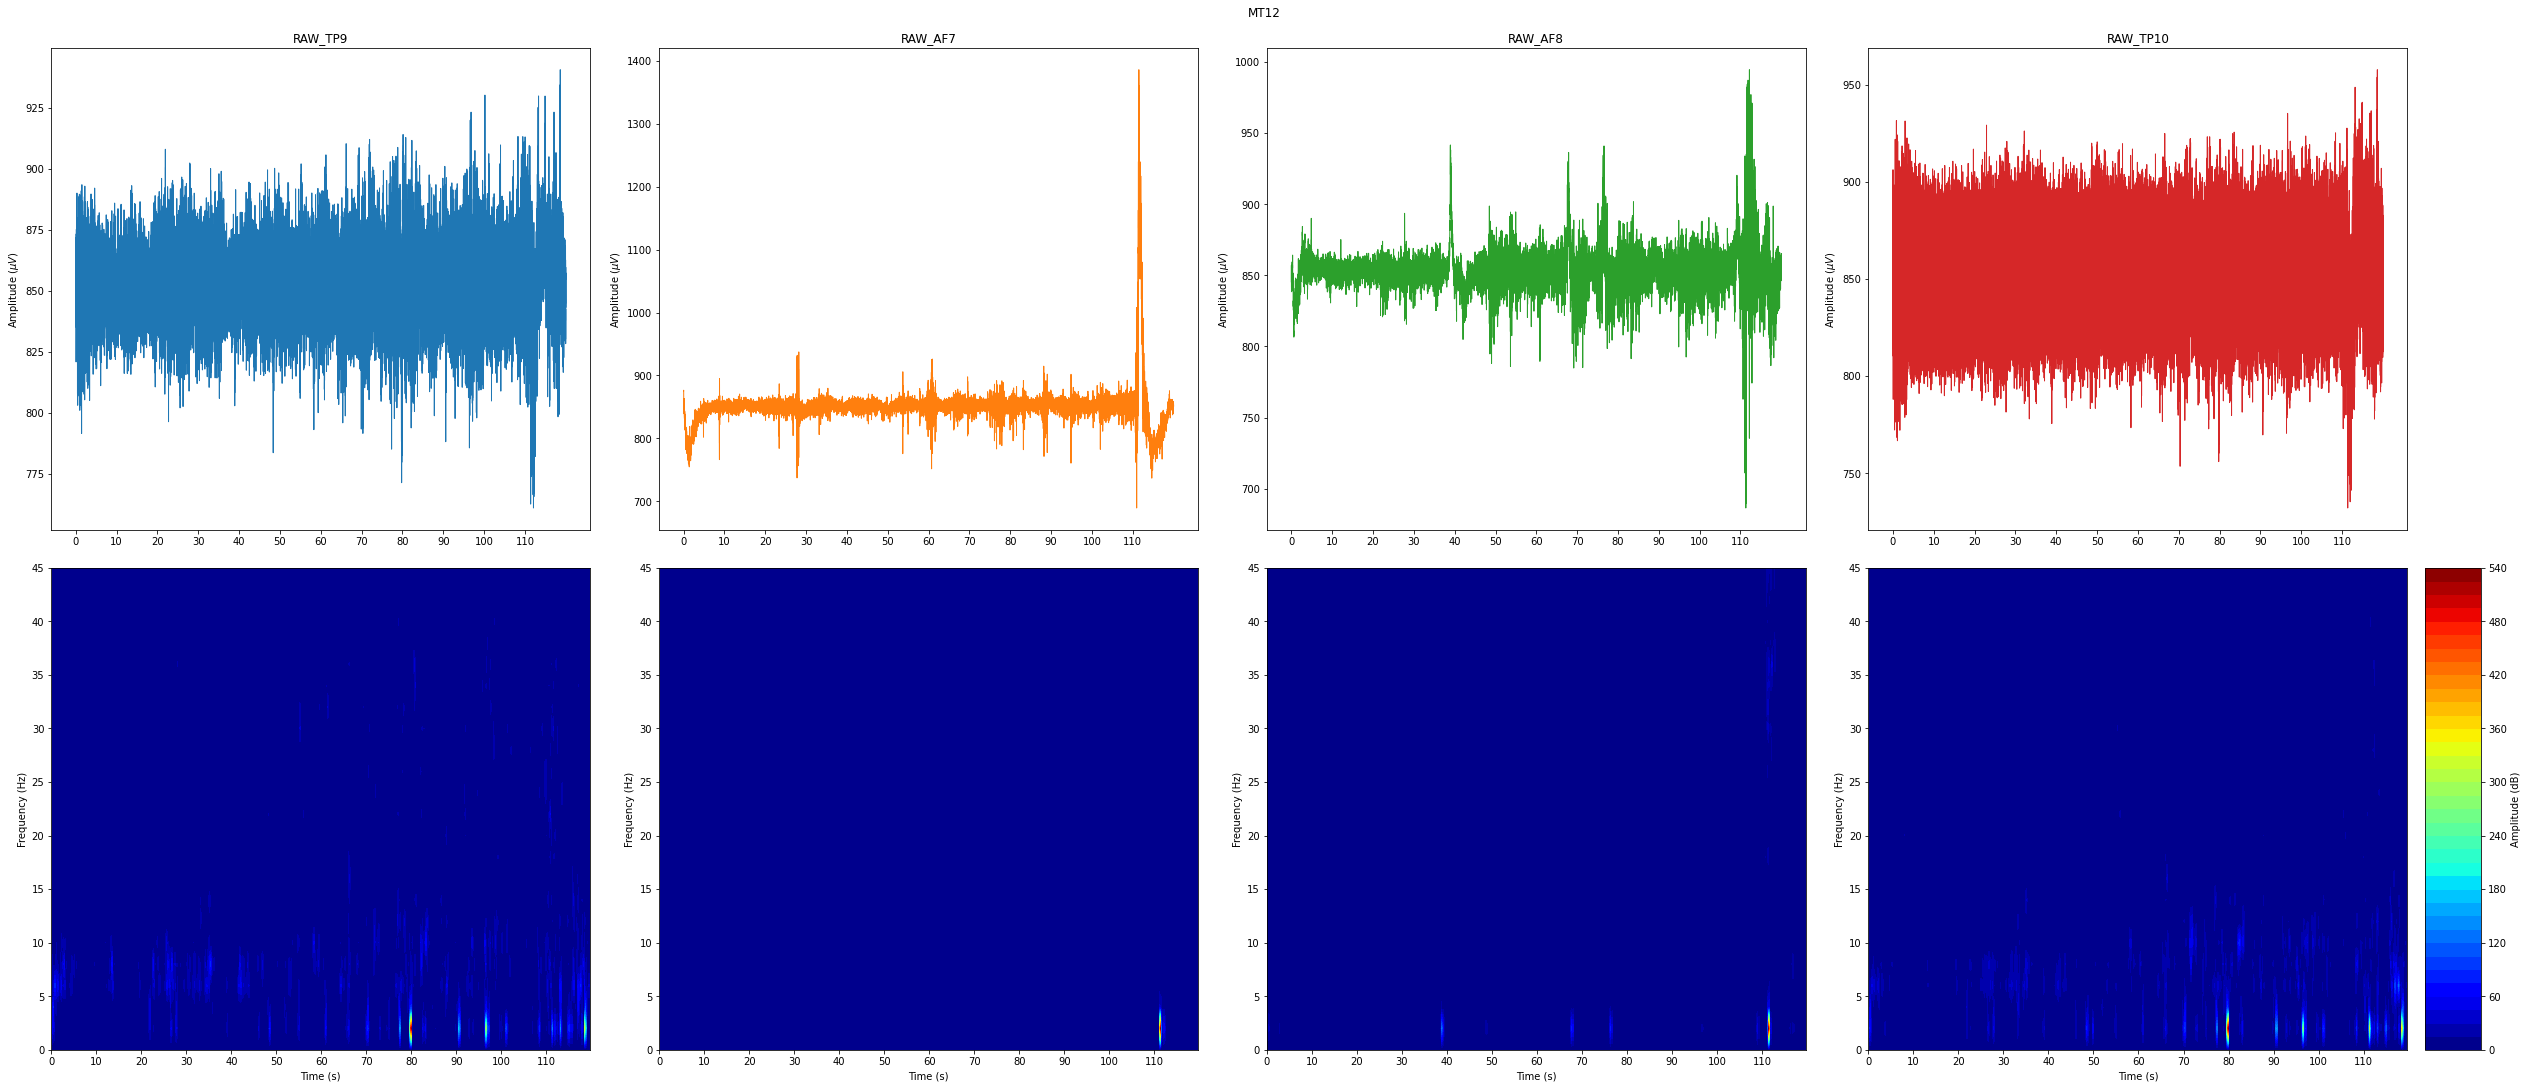

In [17]:
MT11 = zipExtract(M[0],localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
MT11 = MT11.reshape(MT11.shape[1],MT11.shape[2])
MT12 = zipExtract(M[1],localDir,destDir,"M12",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
MT12 = MT12.reshape(MT12.shape[1],MT12.shape[2])
time_s = zipExtract(M[0],localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[2][0]
time_s = time_s.reshape(len(time_s),1)
time_s = time_s[0:int(cfg.collection_time*cfg.fs)]

plots(data=MT11,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
          title='MT11',tickRange=[0,120],timeFrequencyDomainPlots=True)
plots(data=MT12,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
            title='MT12',tickRange=[0,120],timeFrequencyDomainPlots=True)

Adaptive filter Test

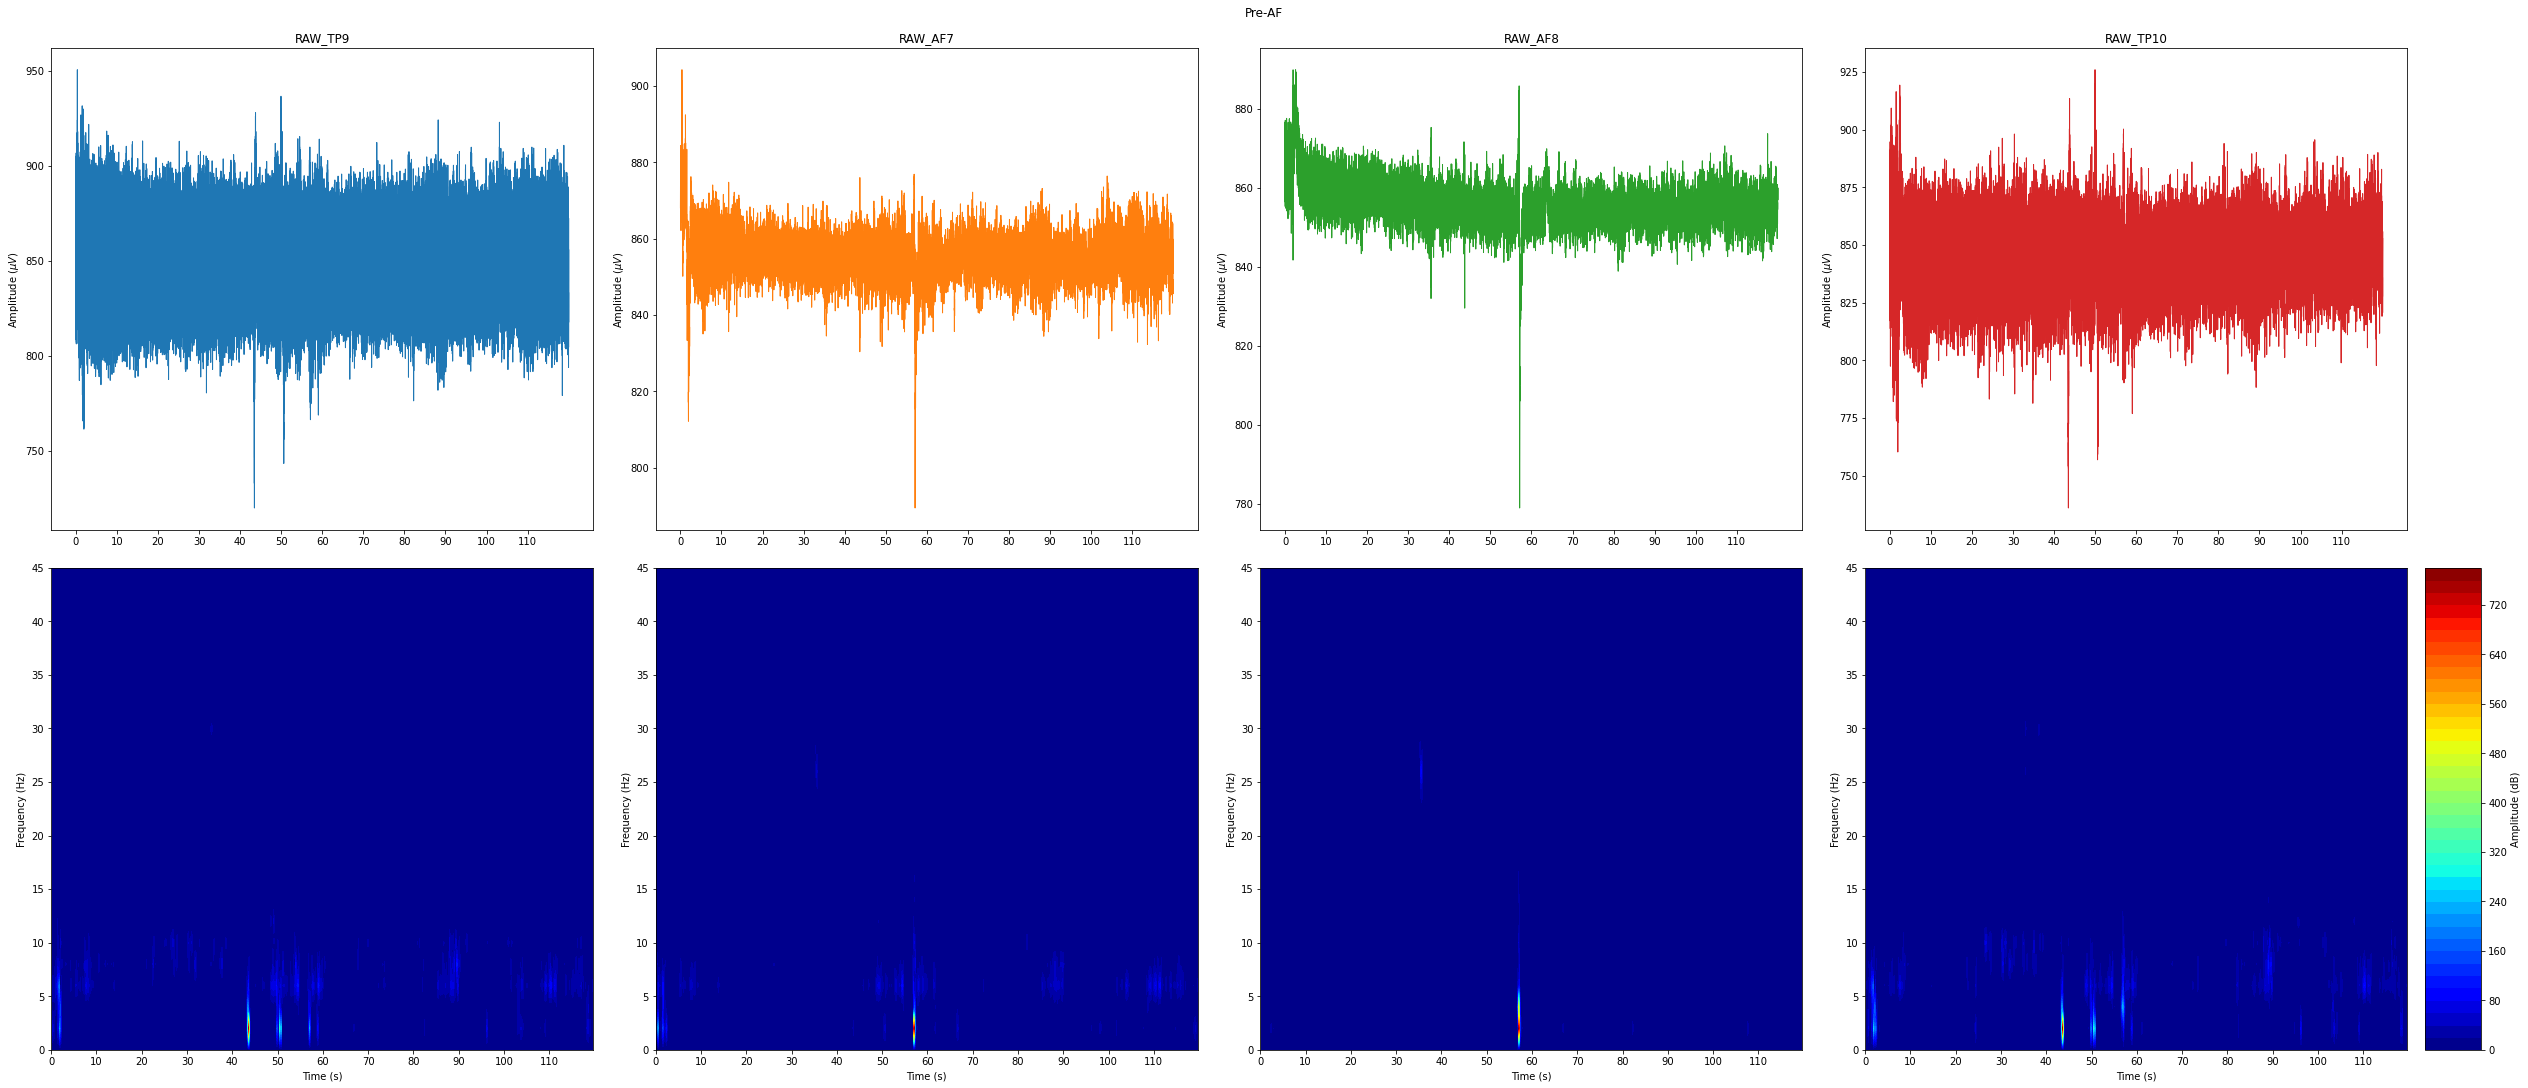

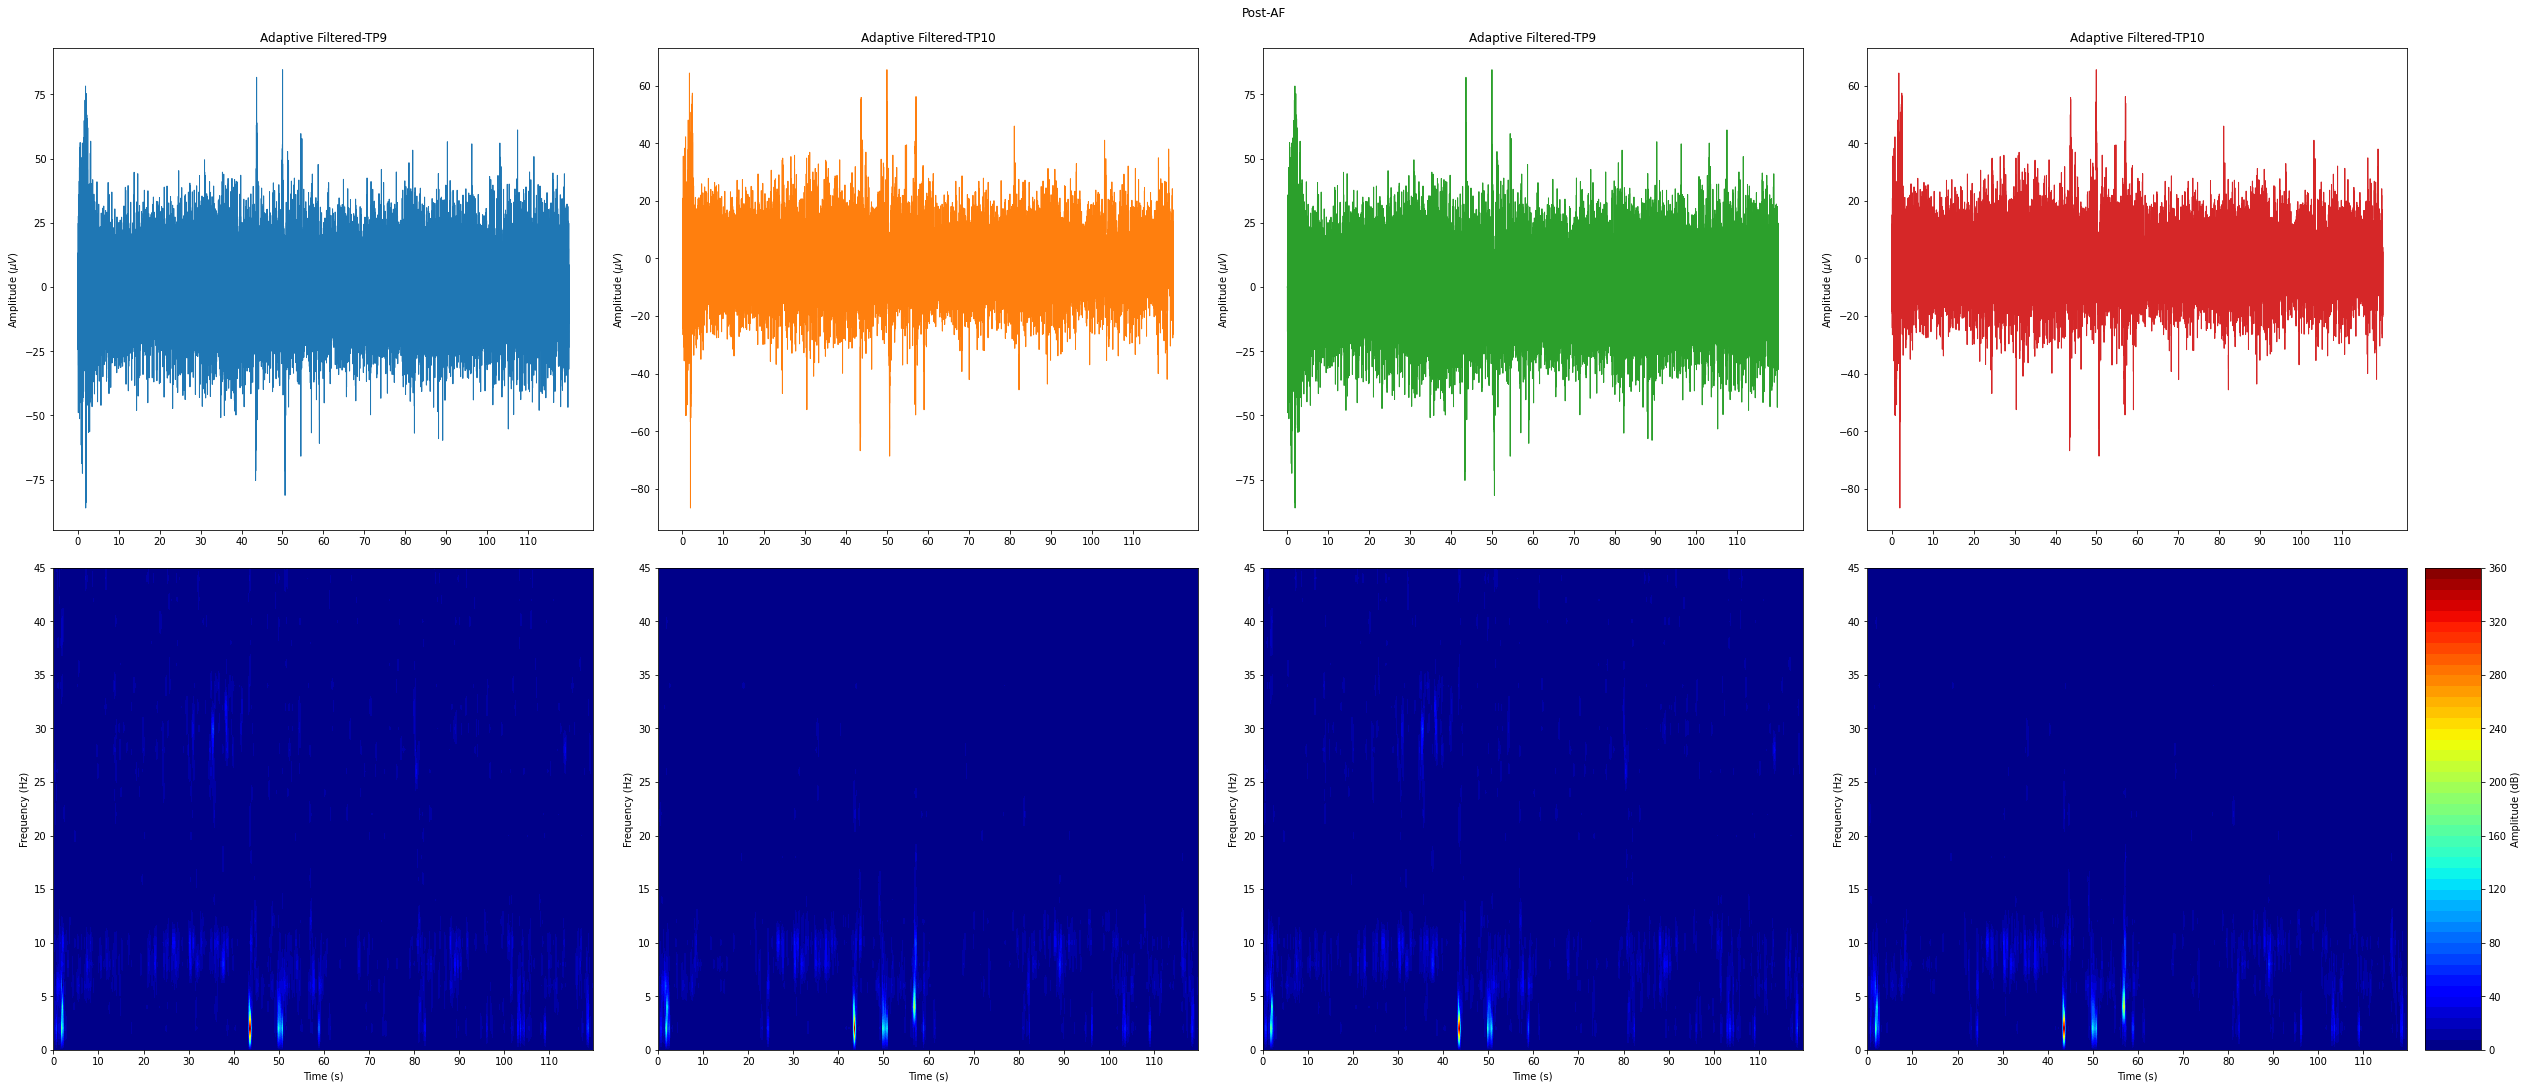

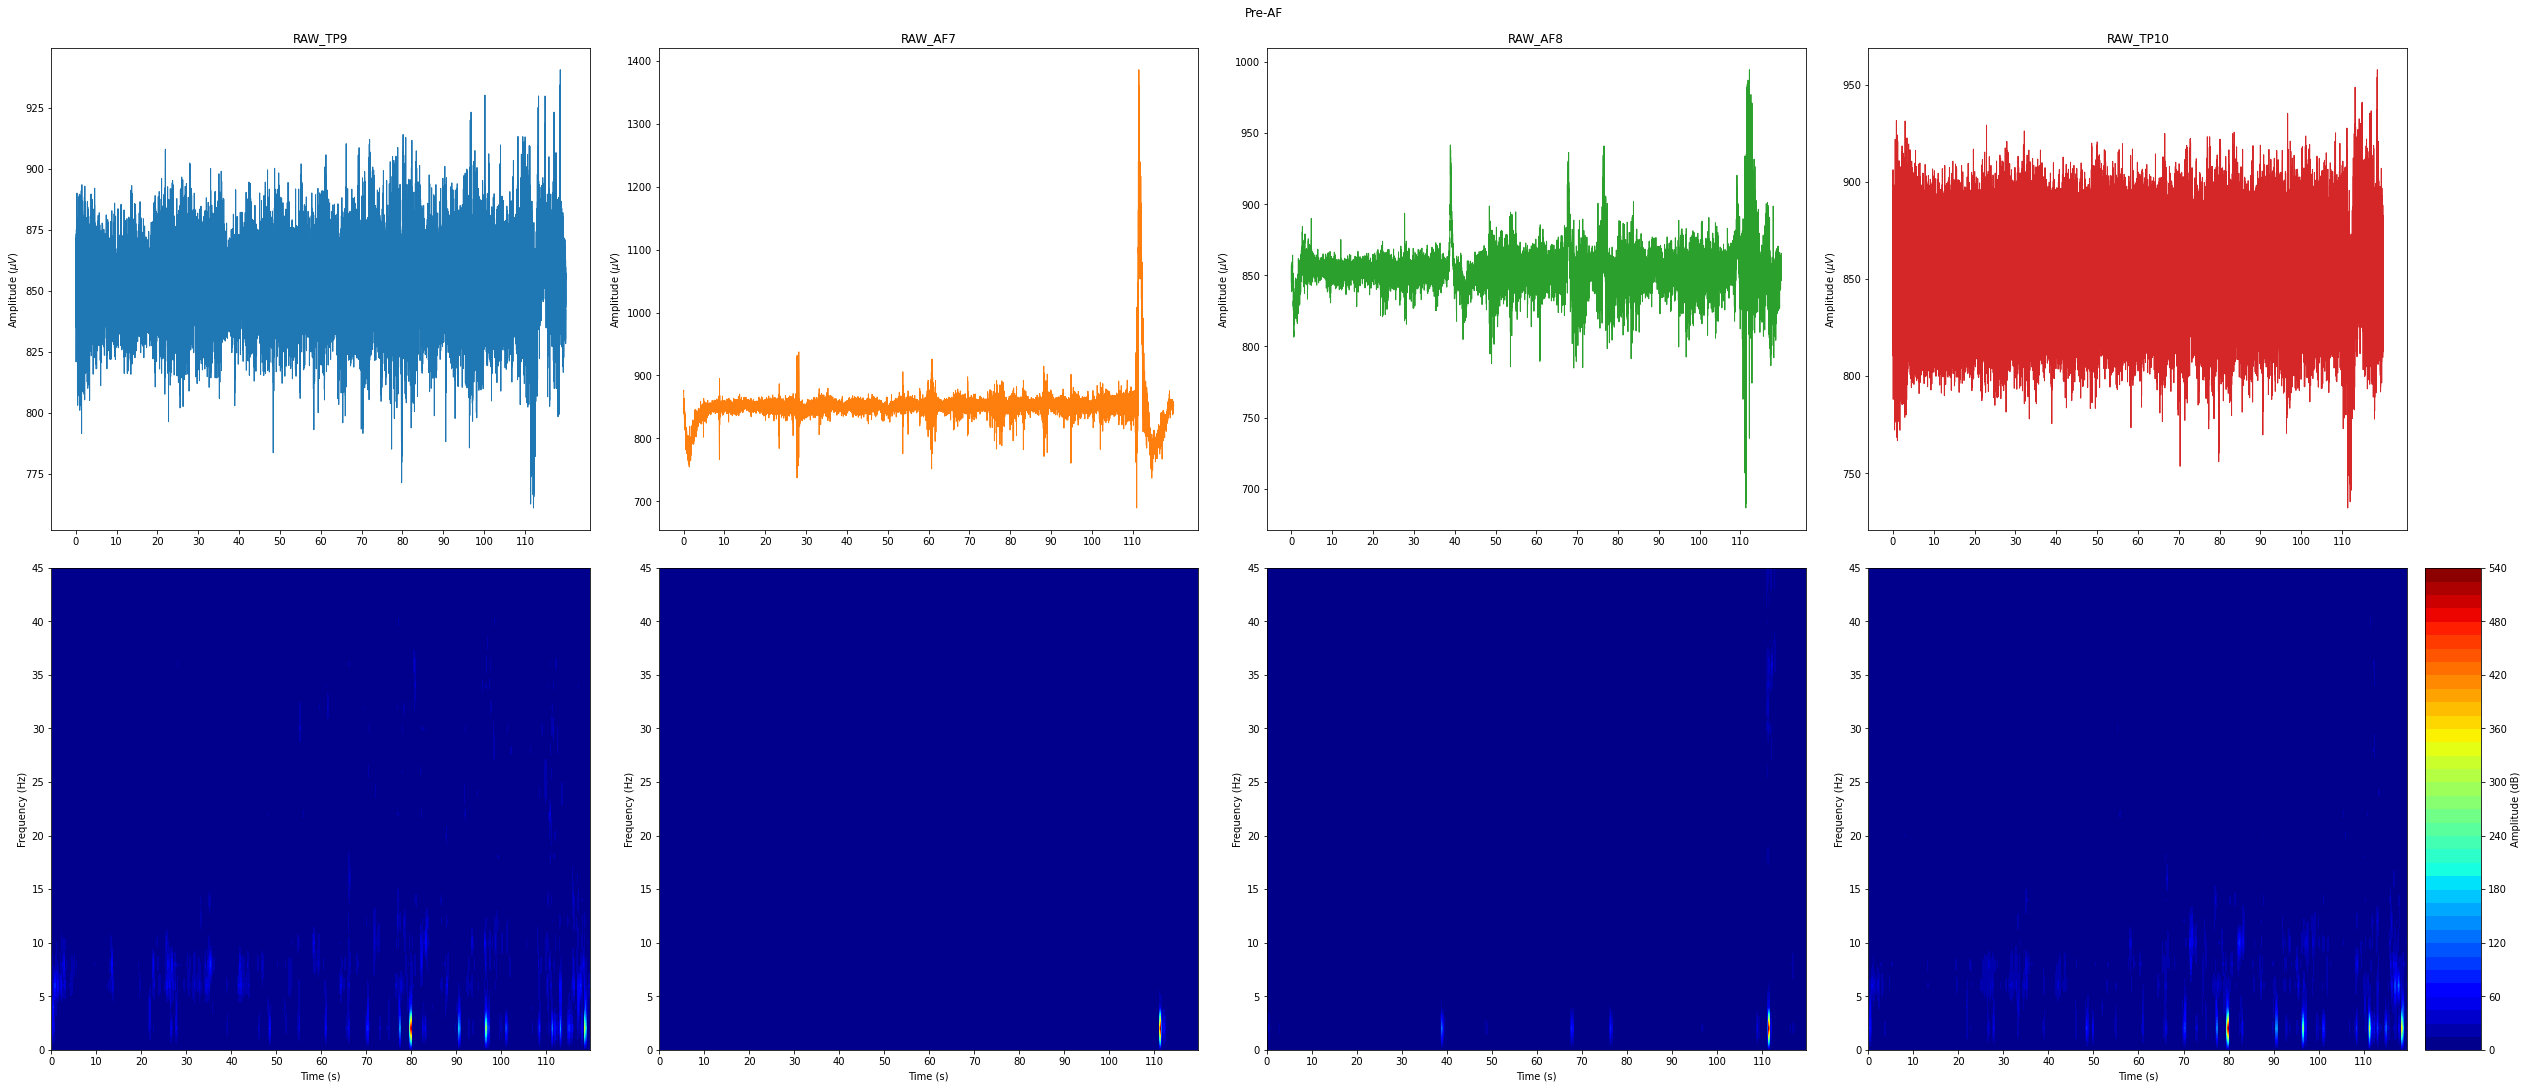

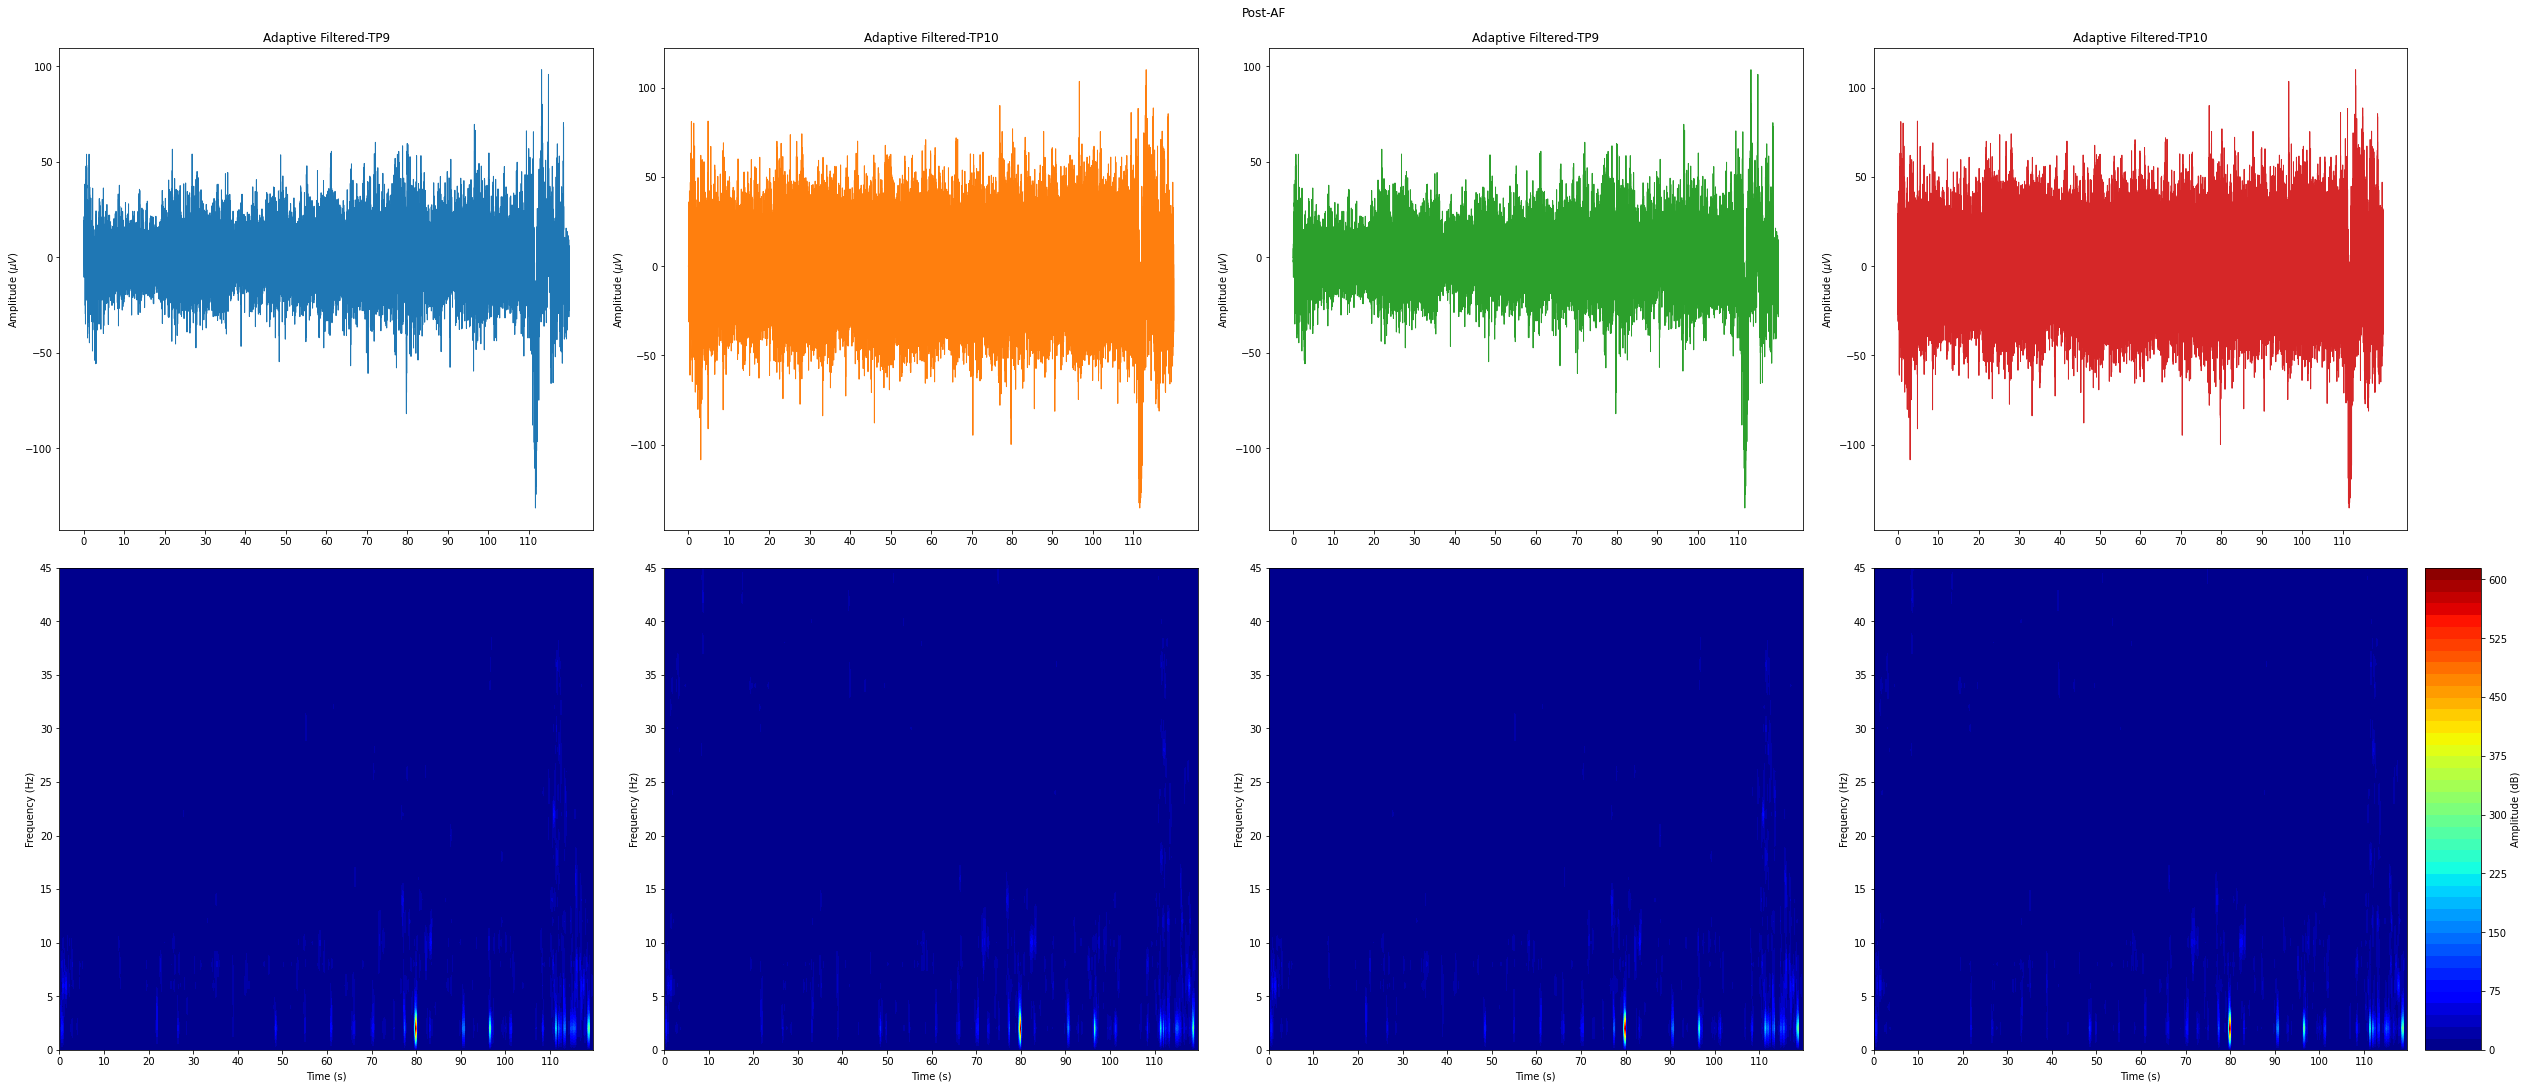

In [20]:
filtering = filters()
eegChan = MT11[:,[0,3]]
eoGChan = MT11[:,[1,2]]
adapMT11 = filtering.adaptive(eegChan,eoGChan)
adapMT11 = np.concatenate((adapMT11,adapMT11),axis=1)

plots(data=MT11,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
          title='Pre-AF',tickRange=[0,120],timeFrequencyDomainPlots=True)
plots(data=adapMT11,time_s=time_s,fs=256,figsize=[35,15],subTitles=['Adaptive Filtered-TP9','Adaptive Filtered-TP10','Adaptive Filtered-TP9','Adaptive Filtered-TP10'],
          title='Post-AF',tickRange=[0,120],timeFrequencyDomainPlots=True)

filtering = filters()
eegChan = MT12[:,[0,3]]
eoGChan = MT12[:,[1,2]]
adapMT12 = filtering.adaptive(eegChan,eoGChan)
adapMT12 = np.concatenate((adapMT12,adapMT12),axis=1)
plots(data=MT12,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
            title='Pre-AF',tickRange=[0,120],timeFrequencyDomainPlots=True)

plots(data=adapMT12,time_s=time_s,fs=256,figsize=[35,15],subTitles=['Adaptive Filtered-TP9','Adaptive Filtered-TP10','Adaptive Filtered-TP9','Adaptive Filtered-TP10'],
          title='Post-AF',tickRange=[0,120],timeFrequencyDomainPlots=True)

In [ ]:
chanInput = eeg[:,0]
imf_chans = emd.sift.sift(chanInput)
def autocorrelation(data):
    x = np.array(data) 
    mean = np.mean(data)
    var = np.var(data)
    ndata = data - mean
    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)
    return acorr
acfs_imf = np.asarray([autocorrelation(imf_chans[:,i]) for i in range(imf_chans.shape[1])]).T
acfs_chanInput = autocorrelation(chanInput)
def mutual_information(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi
mi = np.asarray([mutual_information(acfs_imf[:,i],acfs_chanInput, 100) for i in range(acfs_imf.shape[1])])
miNorm = mi / np.amax(mi)
if np.amax(miNorm)-np.amin(miNorm) < 0.8:
    theta = 0.5*(miNorm[2]-miNorm[0])+miNorm[0]
    idxs = np.where(miNorm > theta)[0]
    cleanIMF = imf_chans[:,idxs]
    sig = np.sum(cleanIMF,axis=1)

Denoised!
Denoised!
Denoised!
Denoised!


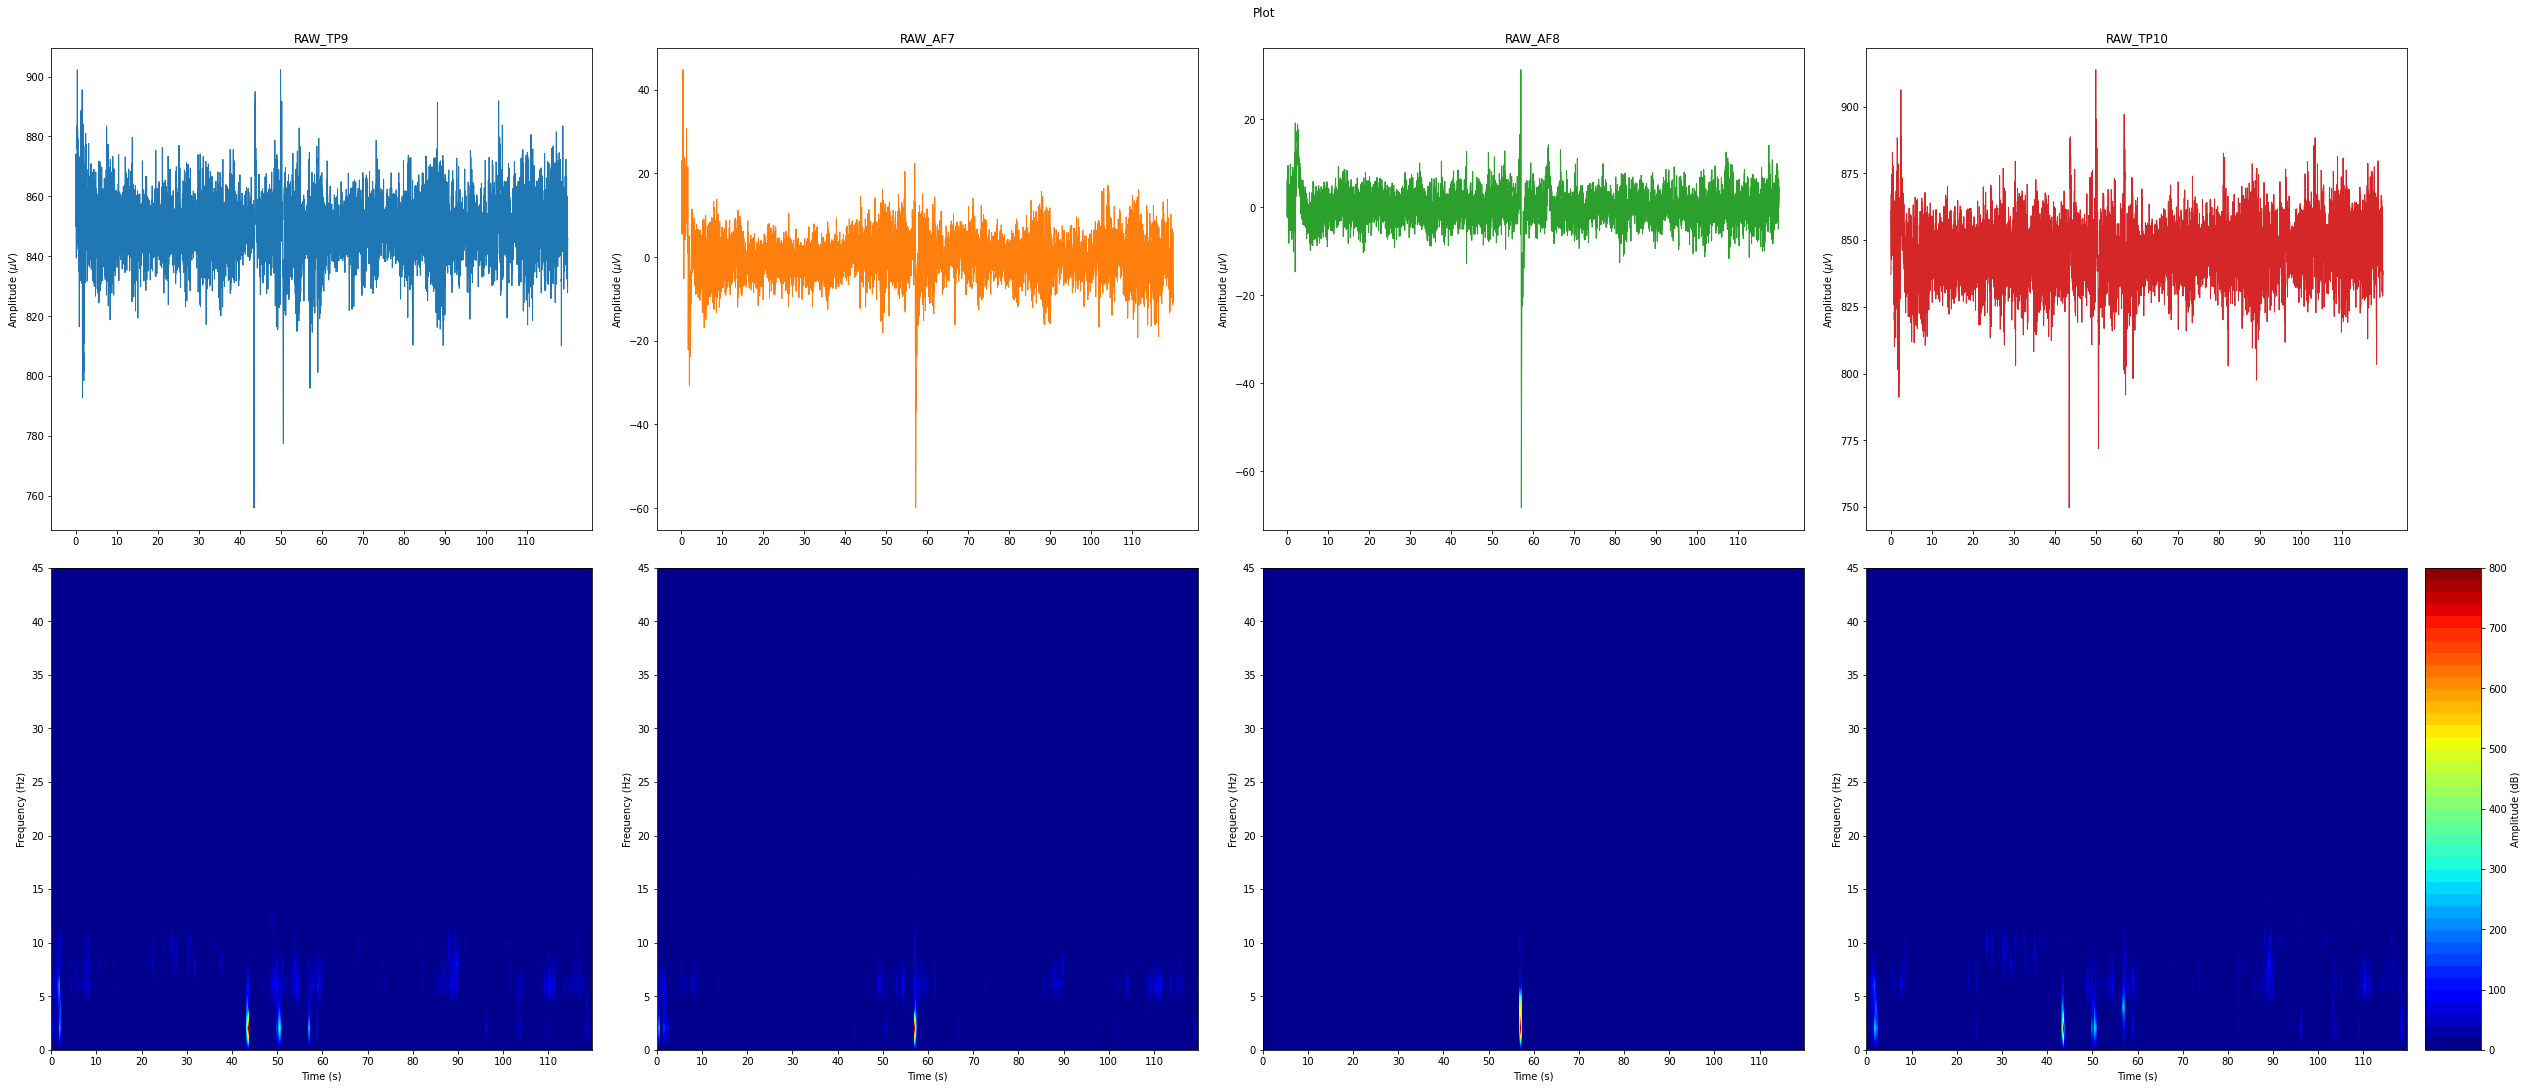

In [10]:
def EMDMI(input):
    def params(chanInput):
        imf_chans = emd.sift.sift(chanInput)
        def autocorrelation(data):
            x = np.array(data) 
            mean = np.mean(data)
            var = np.var(data)
            ndata = data - mean
            acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
            acorr = acorr / var / len(ndata)
            return acorr
        acfs_imf = np.asarray([autocorrelation(imf_chans[:,i]) for i in range(imf_chans.shape[1])]).T
        acfs_chanInput = autocorrelation(chanInput)
        def mutual_information(x, y, bins):
            c_xy = np.histogram2d(x, y, bins)[0]
            mi = mutual_info_score(None, None, contingency=c_xy)
            return mi
        mi = np.asarray([mutual_information(acfs_imf[:,i],acfs_chanInput, 100) for i in range(acfs_imf.shape[1])])
        miNorm = mi / np.amax(mi)
        if np.amax(miNorm)-np.amin(miNorm) < 0.8:
            print("Denoised!")
            theta = 0.5*(miNorm[2]-miNorm[0])+miNorm[0]
            idxs = np.where(miNorm < theta)[0]
            cleanIMF = imf_chans[:,idxs]
            sig = np.sum(cleanIMF,axis=1)
        if np.amax(miNorm)-np.amin(miNorm) > 0.8:
            print("Not Denoised!")
            sig = np.sum(imf_chans,axis=1)
        return sig
    output = []
    for i in range(len(input.T)):
        output.append(params(input[:,i]))
    output = np.asarray(output).T
    return output


denoise = EMDMI(MT11)
plots(data=denoise,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
          title='Plot',tickRange=[0,120],timeFrequencyDomainPlots=True)

In [ ]:
n_eegM1,n_eegM2 = EMDMI(MT11),EMDMI(MT12)
plots(data=n_eegM1,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
            title='EEGM1',tickRange=[0,120],timeFrequencyDomainPlots=True)
plots(data=n_eegM2,time_s=time_s,fs=256,figsize=[35,15],subTitles=['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10'],
            title='EEGM2',tickRange=[0,120],timeFrequencyDomainPlots=True)

In [ ]:
m1_delta = avgBandPower(n_eegM1,256,0.5,4)
m2_delta = avgBandPower(n_eegM2,256,0.5,4)
m1_theta = avgBandPower(n_eegM1,256,4,8)
m2_theta = avgBandPower(n_eegM2,256,4,8)
m1_alpha = avgBandPower(n_eegM1,256,8,12)
m2_alpha = avgBandPower(n_eegM2,256,8,12)
m1_beta = avgBandPower(n_eegM1,256,12,30)
m2_beta = avgBandPower(n_eegM2,256,12,30)
m1_gamma = avgBandPower(n_eegM1,256,30,50)
m2_gamma = avgBandPower(n_eegM2,256,30,50)
print("Delta:",m1_delta,m2_delta)
print("Theta:",m1_theta,m2_theta)
print("Alpha:",m1_alpha,m2_alpha)
print("Beta:",m1_beta,m2_beta)
print("Gamma:",m1_gamma,m2_gamma)

In [ ]:
import emd
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score


chanInput = eeg[:,0]
imf_chans = emd.sift.sift(chanInput)
def autocorrelation(data):
    x = np.array(data) 
    mean = np.mean(data)
    var = np.var(data)
    ndata = data - mean
    acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
    acorr = acorr / var / len(ndata)
    return acorr
acfs_imf = np.asarray([autocorrelation(imf_chans[:,i]) for i in range(imf_chans.shape[1])]).T
acfs_chanInput = autocorrelation(chanInput)
def mutual_information(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi
mi = np.asarray([mutual_information(acfs_imf[:,i],acfs_chanInput, 100) for i in range(acfs_imf.shape[1])])
miNorm = mi / np.amax(mi)
if np.amax(miNorm)-np.amin(miNorm) < 0.8:
    theta = 0.5*(miNorm[2]-miNorm[0])+miNorm[0]
    idxs = np.where(miNorm > theta)[0]
    cleanIMF = imf_chans[:,idxs]
    sig = np.sum(cleanIMF,axis=1)


def EMDMI(input):
    def params(chanInput):
        imf_chans = emd.sift.sift(chanInput)
        def autocorrelation(data):
            x = np.array(data) 
            mean = np.mean(data)
            var = np.var(data)
            ndata = data - mean
            acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
            acorr = acorr / var / len(ndata)
            return acorr
        acfs_imf = np.asarray([autocorrelation(imf_chans[:,i]) for i in range(imf_chans.shape[1])]).T
        acfs_chanInput = autocorrelation(chanInput)
        def mutual_information(x, y, bins):
            c_xy = np.histogram2d(x, y, bins)[0]
            mi = mutual_info_score(None, None, contingency=c_xy)
            return mi
        mi = np.asarray([mutual_information(acfs_imf[:,i],acfs_chanInput, 100) for i in range(acfs_imf.shape[1])])
        miNorm = mi / np.amax(mi)
        if np.amax(miNorm)-np.amin(miNorm) < 0.8:
            print("Denoised!")
            theta = 0.5*(miNorm[2]-miNorm[0])+miNorm[0]
            idxs = np.where(miNorm < theta)[0]
            cleanIMF = imf_chans[:,idxs]
            sig = np.sum(cleanIMF,axis=1)
        if np.amax(miNorm)-np.amin(miNorm) > 0.8:
            print("Not Denoised!")
            sig = np.sum(imf_chans,axis=1)
        return sig
    output = []
    for i in range(len(input.T)):
        output.append(params(input[:,i]))
    output = np.asarray(output).T
    return output